### Import

In [ ]:

!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime
import sys
from catboost import CatBoostRegressor,Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
import seaborn as sns

In [ ]:
from google.colab import drive
from importlib import reload

drive.mount('/content/gdrive',force_remount = True)


Mounted at /content/gdrive


### utils module import

In [ ]:
if 'gdrive.MyDrive.utils' not in sys.modules:
  import  gdrive.MyDrive.utils as utils
else:
  print("utils reload")
  reload(utils)

if 'gdrive.MyDrive.data_EDA' not in sys.modules:
  import gdrive.MyDrive.data_EDA as EDA
else:
  print('eda module reload')
  reload(EDA)

version 1


In [ ]:
project_name = '소득예측'

### util 설정

In [ ]:
utils.seed_everything(253794)
utils.set_dir(project_name)

현재 폴더 :  /content/gdrive/MyDrive/data/소득예측
데이터 위치 :  /content/gdrive/MyDrive/data/소득예측/sample_data
submission 위치 :  /content/gdrive/MyDrive/data/소득예측/sample_data


### Load Data

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv


<Axes: xlabel='Income', ylabel='Density'>

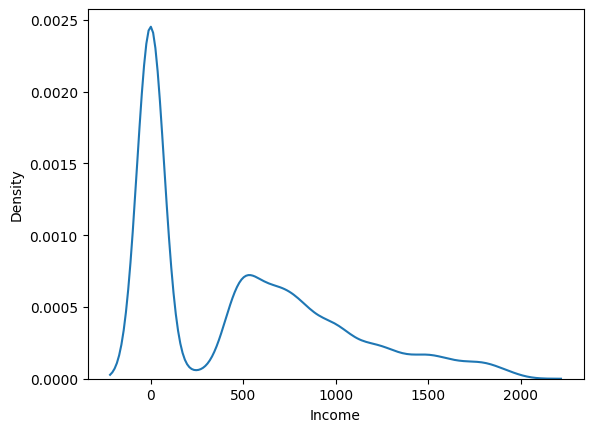

In [ ]:
train, test, submission = utils.get_data()
train.head(5)
sns.kdeplot(train[train['Income']<2000]['Income'])

In [18]:
def drop_cols(train,test):
  train_x = train.drop(columns=['ID','Household_Status','Income'])
  test_x = test.drop(columns=['ID','Household_Status'])
  return train_x, test_x

def adjust_under_median(train_x,train_y):
  # train_y[(train_x['Income_Status']=='Under Median') & (train_y>1500)] = train_y[(train_x['Income_Status']=='Under Median') & (train_y>1500)]*0.1
  # train_y[(train_x['Income_Status']!='Under Median') & (train_y>2000)] = train_y[(train_x['Income_Status']!='Under Median') &(train_y>2000)]*0.1 + 2000
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>3000)] /= 10


def log_scale_income(train_y,scale):
  train_y = np.log(train_y+scale)
  return train_y

In [19]:
def data_processing(train,test, use_valid=False):
  train_y = train['Income']
  train_x, test_x = drop_cols(train,test)
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
  adjust_under_median(train_x, train_y)
  use_log = True
  if use_valid:
    trainset_x,  validset_x,trainset_y, validset_y =  train_test_split(train_x, train_y, test_size=0.1,stratify=train['Income']//2000)
    if use_log:
      trainset_y = log_scale_income(trainset_y,10000)
      validset_y = log_scale_income(validset_y,10000)
    return trainset_x, trainset_y, validset_x, validset_y, test_x
  if use_log:
    train_y = log_scale_income(train_y,10000)
  return train_x, train_y, test_x


### Model 2-1 : onehot3, under median 2000
score : 539.7975133736

In [ ]:
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
# train_x.info()
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']
print(cat_features)

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv
['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']


<ipython-input-46-2c34f2ca9c42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-45-406fe953f287>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>2000)] /= 10


In [ ]:

train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500, one_hot_max_size=3)
cat_model.fit(train_pool)
test_x.info()
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0]=0
display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/one_hot3.csv', index=False)

Learning rate set to 0.115473
0:	learn: 0.0537690	total: 50.5ms	remaining: 25.2s


KeyboardInterrupt: 

### 모델 2-2. catboost under median 3000, onehot3

In [ ]:
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']


load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv


<ipython-input-51-2c34f2ca9c42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-50-86eb4f1f90e5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>3000)] /= 10


Learning rate set to 0.115473
0:	learn: 0.0554923	total: 110ms	remaining: 54.7s
50:	learn: 0.0452515	total: 2.77s	remaining: 24.4s
100:	learn: 0.0446679	total: 5.25s	remaining: 20.8s
150:	learn: 0.0442884	total: 7.91s	remaining: 18.3s
200:	learn: 0.0438960	total: 13s	remaining: 19.4s
250:	learn: 0.0434627	total: 16.5s	remaining: 16.4s
300:	learn: 0.0431638	total: 19.7s	remaining: 13s
350:	learn: 0.0428615	total: 25.6s	remaining: 10.9s
400:	learn: 0.0425461	total: 30.5s	remaining: 7.54s
450:	learn: 0.0422265	total: 34.9s	remaining: 3.79s
499:	learn: 0.0420255	total: 39.3s	remaining: 0us


<ipython-input-55-5793fd9697f9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0]=0


,ID,Income
0,TEST_0000,34.722002
1,TEST_0001,0.000000
2,TEST_0002,413.545523
3,TEST_0003,619.767347
4,TEST_0004,0.000000
5,TEST_0005,723.336809
6,TEST_0006,429.650836
7,TEST_0007,0.864192
8,TEST_0008,0.000000
9,TEST_0009,988.732520


,Income
count,10000.000000
mean,531.325439
std,369.676197
min,0.000000
25%,298.127986
50%,549.900574
75%,783.048013
max,1935.640513


<Axes: ylabel='Density'>

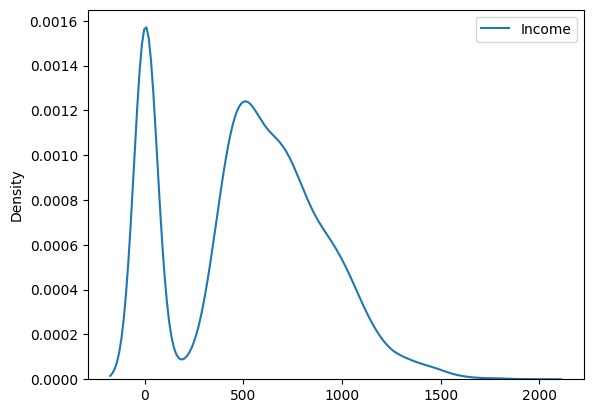

In [ ]:
train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0]=0
display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/one_hot3_under3000.csv', index=False)

### Model 2-3 : under median 4000

In [ ]:
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']


load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv


<ipython-input-61-2c34f2ca9c42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-60-268a7e04f5eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>4000)] /= 10


Learning rate set to 0.115473
0:	learn: 0.0558793	total: 52.7ms	remaining: 26.3s
50:	learn: 0.0457171	total: 2.57s	remaining: 22.6s
100:	learn: 0.0451705	total: 5.15s	remaining: 20.4s
150:	learn: 0.0447999	total: 10.7s	remaining: 24.8s
200:	learn: 0.0443283	total: 13.7s	remaining: 20.3s
250:	learn: 0.0439628	total: 16.4s	remaining: 16.3s
300:	learn: 0.0436004	total: 19.5s	remaining: 12.9s
350:	learn: 0.0432752	total: 23.7s	remaining: 10.1s
400:	learn: 0.0429751	total: 26.4s	remaining: 6.52s
450:	learn: 0.0426993	total: 29.1s	remaining: 3.16s
499:	learn: 0.0424107	total: 31.9s	remaining: 0us


<ipython-input-63-ad54f7e6e5f7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0]=0


,ID,Income
0,TEST_0000,32.073595
1,TEST_0001,14.005647
2,TEST_0002,401.871571
3,TEST_0003,645.339659
4,TEST_0004,0.000000
5,TEST_0005,727.005126
6,TEST_0006,405.053797
7,TEST_0007,3.135254
8,TEST_0008,0.730713
9,TEST_0009,1037.369881


,Income
count,10000.000000
mean,535.400728
std,371.950887
min,0.000000
25%,298.742587
50%,551.775361
75%,790.488346
max,1833.193935


<Axes: ylabel='Density'>

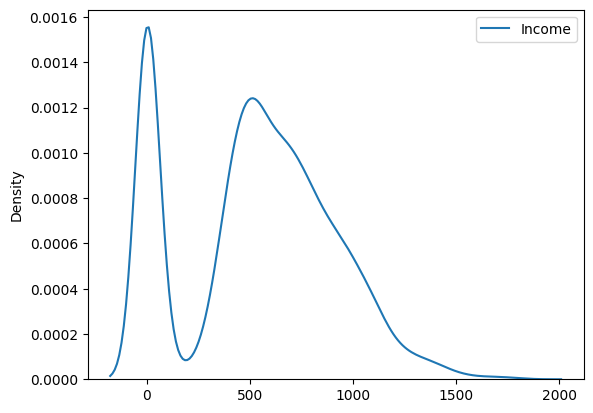

In [ ]:
train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0]=0
display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/one_hot3_under000.csv', index=False)

### Model 2-4 : validation set 준비

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train, test, submission = utils.get_data()
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
# train_x, train_y, valid_x, valid_y, test_x = data_processing(train,test,True)
# print(len(train_x),len(train_y), len(valid_x),len(valid_y))
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']
print(cat_features)

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv
['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']


<ipython-input-21-c8b9309b261f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-8-268a7e04f5eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>4000)] /= 10


Learning rate set to 0.065727
0:	learn: 0.0566857	total: 126ms	remaining: 2m 6s
50:	learn: 0.0462562	total: 3.04s	remaining: 56.6s
100:	learn: 0.0456170	total: 5.52s	remaining: 49.2s
150:	learn: 0.0452336	total: 7.89s	remaining: 44.4s
200:	learn: 0.0450017	total: 10.4s	remaining: 41.3s
250:	learn: 0.0447641	total: 14.8s	remaining: 44.1s
300:	learn: 0.0445455	total: 17.4s	remaining: 40.4s
350:	learn: 0.0443528	total: 20s	remaining: 37s
400:	learn: 0.0441483	total: 22.7s	remaining: 33.9s
450:	learn: 0.0438339	total: 25.7s	remaining: 31.2s
500:	learn: 0.0436405	total: 29.7s	remaining: 29.6s
550:	learn: 0.0434457	total: 32.4s	remaining: 26.4s
600:	learn: 0.0432659	total: 35.1s	remaining: 23.3s
650:	learn: 0.0431153	total: 37.7s	remaining: 20.2s
700:	learn: 0.0429808	total: 41.8s	remaining: 17.8s
750:	learn: 0.0428284	total: 44.8s	remaining: 14.9s
800:	learn: 0.0426850	total: 47.5s	remaining: 11.8s
850:	learn: 0.0425098	total: 50.2s	remaining: 8.79s
900:	learn: 0.0423563	total: 54.2s	remain

<ipython-input-37-3121c085b308>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0] = 0


,ID,Income
0,TEST_0000,34.006945
1,TEST_0001,24.151440
2,TEST_0002,407.197451
3,TEST_0003,661.608338
4,TEST_0004,0.000000
5,TEST_0005,732.194515
6,TEST_0006,410.914073
7,TEST_0007,1.367918
8,TEST_0008,3.829726
9,TEST_0009,1074.023663


,Income
count,10000.000000
mean,534.435126
std,372.509430
min,0.000000
25%,295.877396
50%,548.963550
75%,791.328398
max,1917.846522


<Axes: ylabel='Density'>

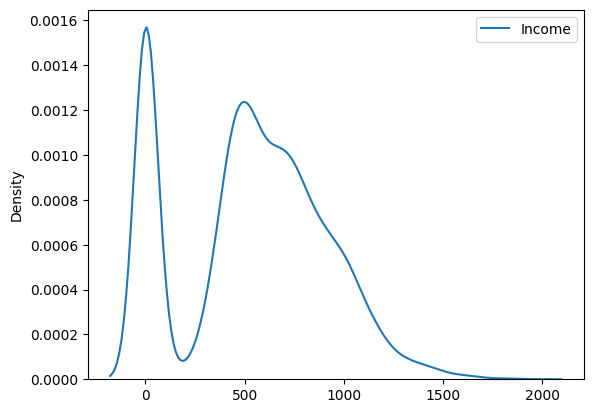

In [ ]:
train_pool = Pool(train_x, train_y, cat_features=cat_features)
# valid_pool = Pool(valid_x, valid_y, cat_features = cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500)
# cat_model.fit(train_pool, eval_set=valid_pool)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0] = 0
# submission['Income'][test_x['Working_Week (Yearly)']==0] = 0
# submission['Income'][test['Age']<15]=0
display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/n_estimators500.csv', index=False)

### Model 2-5 : Seed search

In [ ]:
# train, test, submission = utils.get_data()
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
# train_x, train_y, valid_x, valid_y, test_x = data_processing(train,test,True)
# print(len(train_x),len(train_y), len(valid_x),len(valid_y))
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']
print(cat_features)

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv
['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']


<ipython-input-14-c8b9309b261f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-13-86eb4f1f90e5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>3000)] /= 10


Learning rate set to 0.115473
0:	learn: 0.0554377	total: 104ms	remaining: 51.8s
50:	learn: 0.0452170	total: 2.51s	remaining: 22.1s
100:	learn: 0.0444699	total: 4.89s	remaining: 19.3s
150:	learn: 0.0438730	total: 7.38s	remaining: 17.1s
200:	learn: 0.0433856	total: 10.3s	remaining: 15.4s
250:	learn: 0.0430333	total: 14.2s	remaining: 14.1s
300:	learn: 0.0427380	total: 16.7s	remaining: 11.1s
350:	learn: 0.0424071	total: 19.3s	remaining: 8.18s
400:	learn: 0.0420750	total: 21.8s	remaining: 5.38s
450:	learn: 0.0417774	total: 25.5s	remaining: 2.77s
499:	learn: 0.0415343	total: 28.6s	remaining: 0us


<ipython-input-20-c421d386d820>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0] = 0


,ID,Income
0,TEST_0000,25.397151
1,TEST_0001,32.175907
2,TEST_0002,409.808997
3,TEST_0003,643.910872
4,TEST_0004,0.000000
5,TEST_0005,780.759954
6,TEST_0006,406.506417
7,TEST_0007,3.941524
8,TEST_0008,13.922471
9,TEST_0009,1043.014275


,Income
count,10000.000000
mean,532.186031
std,373.973776
min,0.000000
25%,280.463149
50%,541.371903
75%,787.466349
max,1943.715768


<Axes: ylabel='Density'>

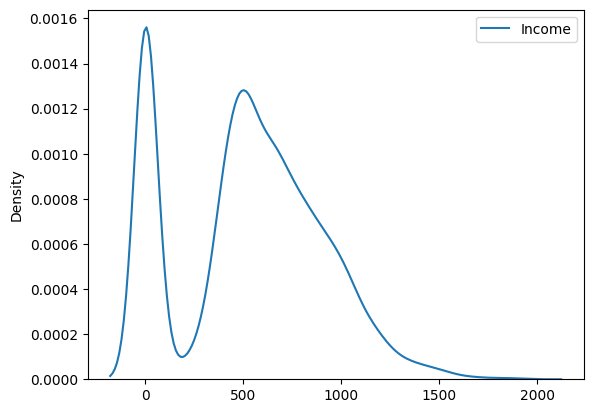

In [ ]:
utils.seed_everything(311)
train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500,random_seed=311)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0] = 0

display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/seed311.csv', index=False)

In [ ]:
### Model 2-6 : cut income > 2000

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv


<ipython-input-22-c8b9309b261f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-70-f8f01791cc35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>500)] = train_y[(train_x['Income_Status']=='Under Median') & (train_y>500)]*0.1


['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
Learning rate set to 0.115473
0:	learn: 0.0401652	total: 49.6ms	remaining: 24.8s
50:	learn: 0.0290902	total: 2.47s	remaining: 21.7s
100:	learn: 0.0285783	total: 4.95s	remaining: 19.6s
150:	learn: 0.0281821	total: 7.52s	remaining: 17.4s
200:	learn: 0.0278771	total: 12s	remaining: 17.9s
250:	learn: 0.0275464	total: 14.7s	remaining: 14.6s
300:	learn: 0.0272803	total: 17.4s	remaining: 11.5s
350:	learn: 0.0270455	total: 20s	remaining: 8.51s
400:	learn: 0.0267669	total: 23.8s	remaining: 5.87s
450:	learn: 0.0265389	total: 27.3s	remaining: 2.96s
499:	learn: 0.0262578	total: 30s	remaining: 0us


<ipython-input-73-33b75da984a5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0] = 0


,ID,Income
0,TEST_0000,1.067141
1,TEST_0001,6.112492
2,TEST_0002,258.439405
3,TEST_0003,580.885894
4,TEST_0004,0.000000
5,TEST_0005,806.165980
6,TEST_0006,291.199366
7,TEST_0007,0.000000
8,TEST_0008,12.244598
9,TEST_0009,1114.198369


,Income
count,10000.000000
mean,252.710774
std,319.763219
min,0.000000
25%,54.351327
50%,119.763631
75%,323.428034
max,1843.860648


<Axes: ylabel='Density'>

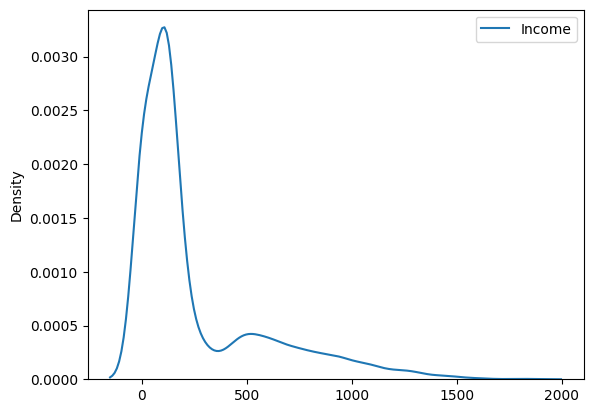

In [ ]:
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']
print(cat_features)
utils.seed_everything(311)
train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-10000
submission['Income'][submission['Income']<0] = 0

display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/income_over_2000_500.csv', index=False)

### Model 2-7 : 기본 모델 서치

load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/train.csv
load from train :  /content/gdrive/MyDrive/data/소득예측/sample_data/test.csv
load from submission :  /content/gdrive/MyDrive/data/소득예측/sample_data/sample_submission.csv
Learning rate set to 0.115473
0:	learn: 0.0554923	total: 38.3ms	remaining: 19.1s


<ipython-input-11-c8b9309b261f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Hispanic_Origin'][train_x['Hispanic_Origin']==' Do not know']=' NA'
<ipython-input-10-918cc54cc86e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_y[(train_x['Income_Status']=='Under Median') & (train_y>3000)] /= 10


50:	learn: 0.0452515	total: 1.83s	remaining: 16.1s
100:	learn: 0.0446679	total: 3.69s	remaining: 14.6s
150:	learn: 0.0442884	total: 5.62s	remaining: 13s
200:	learn: 0.0438960	total: 8.52s	remaining: 12.7s
250:	learn: 0.0434627	total: 10.5s	remaining: 10.4s
300:	learn: 0.0431638	total: 12.4s	remaining: 8.19s
350:	learn: 0.0428615	total: 14.3s	remaining: 6.07s
400:	learn: 0.0425461	total: 16.3s	remaining: 4.03s
450:	learn: 0.0422265	total: 19s	remaining: 2.07s
499:	learn: 0.0420255	total: 21.3s	remaining: 0us


<ipython-input-13-3690c12e1add>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Income'][submission['Income']<0] = 0


,ID,Income
0,TEST_0000,34.722002
1,TEST_0001,0.000000
2,TEST_0002,413.545523
3,TEST_0003,619.767347
4,TEST_0004,0.000000
5,TEST_0005,723.336809
6,TEST_0006,429.650836
7,TEST_0007,0.864192
8,TEST_0008,0.000000
9,TEST_0009,988.732520


,Income
count,10000.000000
mean,531.325439
std,369.676197
min,0.000000
25%,298.127986
50%,549.900574
75%,783.048013
max,1935.640513


<Axes: ylabel='Density'>

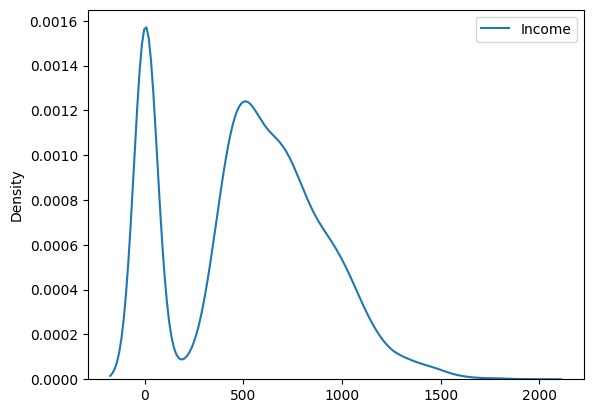

In [ ]:
train, test, submission = utils.get_data()
train_x, train_y, test_x = data_processing(train,test)
cat_features = [key for key in train_x.columns if train_x[key].dtype == 'object']
utils.seed_everything(311)
train_pool = Pool(train_x, train_y, cat_features=cat_features)
cat_model = CatBoostRegressor(verbose=50,iterations=500)
cat_model.fit(train_pool)
test_pool = Pool(test_x, cat_features=cat_features)
preds = cat_model.predict(test_pool)
submission['Income'] = np.exp(preds)-100000
submission['Income'][submission['Income']<0] = 0

display(submission.head(10))
display(submission.describe())
display(sns.kdeplot(submission))
submission.to_csv('/content/gdrive/MyDrive/data/소득예측/sample_data/base_best1.csv', index=False)